# Analysis and Classification with Natural Language

In this notebook we will continue with the data we prepared in the last lecture.  Our goals will be to separate the data into positive and negative tweets, compare and analyze them to notice any differences, and then to create a model to classify future tweets as having a positive or negative sentiment.

# Loading Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.probability import FreqDist
from wordcloud import WordCloud
pd.set_option('display.max_colwidth', None)

# Import Processed Data

We created several versions of our text in the previous lecture.  We will load those again to use for analysis and classification

In [2]:
## Load processed data
df = pd.read_csv('../Data/processed_data.csv')
df.head()

,text,sentiment,length,lower_text,tokens,no_stops,no_stops_no_punct,spacy_lemmas,bigrams
0,"I`d have responded, if I were going",neutral,36,"i`d have responded, if i were going","['i', '`', 'd', 'have', 'responded', ',', 'if', 'i', 'were', 'going']","['`', 'responded', ',', 'going']","['responded', 'going']","['i`d', 'respond', 'go']","[('i`d', 'respond'), ('respond', 'go')]"
1,Sooo SAD I will miss you here in San Diego!!!,negative,46,sooo sad i will miss you here in san diego!!!,"['sooo', 'sad', 'i', 'will', 'miss', 'you', 'here', 'in', 'san', 'diego', '!', '!', '!']","['sooo', 'sad', 'miss', 'san', 'diego', '!', '!', '!']","['sooo', 'sad', 'miss', 'san', 'diego']","['sooo', 'sad', 'miss', 'san', 'diego']","[('sooo', 'sad'), ('sad', 'miss'), ('miss', 'san'), ('san', 'diego')]"
2,my boss is bullying me...,negative,25,my boss is bullying me...,"['my', 'boss', 'is', 'bullying', 'me', '...']","['boss', 'bullying', '...']","['boss', 'bullying', '...']","['boss', 'bully']","[('boss', 'bully')]"
3,what interview! leave me alone,negative,31,what interview! leave me alone,"['what', 'interview', '!', 'leave', 'me', 'alone']","['interview', '!', 'leave', 'alone']","['interview', 'leave', 'alone']","['interview', 'leave']","[('interview', 'leave')]"
4,"Sons of ****, why couldn`t they put them on the releases we already bought",negative,75,"sons of ****, why couldn`t they put them on the releases we already bought","['sons', 'of', '*', '*', '*', '*', ',', 'why', 'couldn', '`', 't', 'they', 'put', 'them', 'on', 'the', 'releases', 'we', 'already', 'bought']","['sons', '*', '*', '*', '*', ',', '`', 'put', 'releases', 'already', 'bought']","['sons', 'put', 'releases', 'already', 'bought']","['son', 'couldn`t', 'release', 'buy']","[('son', 'couldn`t'), ('couldn`t', 'release'), ('release', 'buy')]"


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27480 entries, 0 to 27479
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               27480 non-null  object
 1   sentiment          27480 non-null  object
 2   length             27480 non-null  int64 
 3   lower_text         27480 non-null  object
 4   tokens             27480 non-null  object
 5   no_stops           27480 non-null  object
 6   no_stops_no_punct  27480 non-null  object
 7   spacy_lemmas       27480 non-null  object
 8   bigrams            27480 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.9+ MB


In [4]:
type(df['tokens'][0])

str

## Convert strings of lists to lists

You might recall that pandas interprets lists and strings when importing data.  We can define a quick function to convert them back.

How can we use string methods to do this?

In [5]:
## Function to convert string lists back to lists

def convert_to_list(string):
    """Remove braces, split tokens on commas, and then strip quotes from outside of each token"""
    new_list = [token.strip("' ") for token in string.strip("[]").split(',')]
    return new_list

In [6]:
## applymap function to convert string lists back to lists.

cols = ['tokens','no_stops','no_stops_no_punct', 'spacy_lemmas', 'bigrams']

df[cols] = df[cols].applymap(convert_to_list)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27480 entries, 0 to 27479
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               27480 non-null  object
 1   sentiment          27480 non-null  object
 2   length             27480 non-null  int64 
 3   lower_text         27480 non-null  object
 4   tokens             27480 non-null  object
 5   no_stops           27480 non-null  object
 6   no_stops_no_punct  27480 non-null  object
 7   spacy_lemmas       27480 non-null  object
 8   bigrams            27480 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.9+ MB


In [7]:
## Check type of first row


list

# Class Balance

It's always a good idea to check the class balance when creating a classification model.  This can affect modeling bias and interpretation of metrics.

In [8]:
## Check class balance of 'sentiments'


neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

There are more neutral tweets any any other class, but positive and negative tweets are pretty balanced.

# Divide by Sentiment

Since we want to compare and classify positive vs negative tweets, we will create 2 different datasets: One of positive tweets and one of negative tweets.  We will not use the neutral tweets for this lecture.

In [9]:
## Divide documents by sentiment
positive = df.loc[df['sentiment'] == 'positive']
negative = df.loc[df['sentiment'] == 'negative']
print('Positive Tweets')
display(positive.head())
print('Negative Tweets')
display(negative.head())

Positive Tweets


,text,sentiment,length,lower_text,tokens,no_stops,no_stops_no_punct,spacy_lemmas,bigrams
6,2am feedings for the baby are fun when he is all smiles and coos,positive,64,2am feedings for the baby are fun when he is all smiles and coos,"[2am, feedings, for, the, baby, are, fun, when, he, is, all, smiles, and, coos]","[2am, feedings, baby, fun, smiles, coos]","[2am, feedings, baby, fun, smiles, coos]","[2, feeding, baby, fun, smile, coo]","[('2, feeding'), ('feeding, baby'), ('baby, fun'), ('fun, smile'), ('smile, coo')]"
9,Journey!? Wow... u just became cooler. hehe... (is that possible!?),positive,69,journey!? wow... u just became cooler. hehe... (is that possible!?),"[journey, !, ?, wow, ..., u, just, became, cooler, ., hehe, ..., (, is, that, possible, !, ?, )]","[journey, !, ?, wow, ..., u, became, cooler, ., hehe, ..., (, possible, !, ?, )]","[journey, wow, ..., u, became, cooler, hehe, ..., possible]","[journey, wow, u, cool, hehe, possible]","[('journey, wow'), ('wow, u'), ('u, cool'), ('cool, hehe'), ('hehe, possible')]"
11,I really really like the song Love Story by Taylor Swift,positive,56,i really really like the song love story by taylor swift,"[i, really, really, like, the, song, love, story, by, taylor, swift]","[really, really, like, song, love, story, taylor, swift]","[really, really, like, song, love, story, taylor, swift]","[like, song, love, story, taylor, swift]","[('like, song'), ('song, love'), ('love, story'), ('story, taylor'), ('taylor, swift')]"
21,Playing Ghost Online is really interesting. The new updates are Kirin pet and Metamorph for third job. Can`t wait to have a dragon pet,positive,135,playing ghost online is really interesting. the new updates are kirin pet and metamorph for third job. can`t wait to have a dragon pet,"[playing, ghost, online, is, really, interesting, ., the, new, updates, are, kirin, pet, and, metamorph, for, third, job, ., can, `, t, wait, to, have, a, dragon, pet]","[playing, ghost, online, really, interesting, ., new, updates, kirin, pet, metamorph, third, job, ., `, wait, dragon, pet]","[playing, ghost, online, really, interesting, new, updates, kirin, pet, metamorph, third, job, wait, dragon, pet]","[play, ghost, online, interesting, new, update, kirin, pet, metamorph, job, can`t, wait, dragon, pet]","[('play, ghost'), ('ghost, online'), ('online, interesting'), ('interesting, new'), ('new, update'), ('update, kirin'), ('kirin, pet'), ('pet, metamorph'), ('metamorph, job'), ('job, can`t'), ('can`t, wait'), ('wait, dragon'), ('dragon, pet')]"
25,"the free fillin` app on my ipod is fun, im addicted",positive,51,"the free fillin` app on my ipod is fun, im addicted","[the, free, fillin, `, app, on, my, ipod, is, fun, , , im, addicted]","[free, fillin, `, app, ipod, fun, , , im, addicted]","[free, fillin, app, ipod, fun, im, addicted]","[free, fillin, `, app, ipod, fun, m, addicted]","[('free, fillin'), ('fillin, `'), ('`, app'), ('app, ipod'), ('ipod, fun'), ('fun, m'), ('m, addicted')]"


Negative Tweets


,text,sentiment,length,lower_text,tokens,no_stops,no_stops_no_punct,spacy_lemmas,bigrams
1,Sooo SAD I will miss you here in San Diego!!!,negative,46,sooo sad i will miss you here in san diego!!!,"[sooo, sad, i, will, miss, you, here, in, san, diego, !, !, !]","[sooo, sad, miss, san, diego, !, !, !]","[sooo, sad, miss, san, diego]","[sooo, sad, miss, san, diego]","[('sooo, sad'), ('sad, miss'), ('miss, san'), ('san, diego')]"
2,my boss is bullying me...,negative,25,my boss is bullying me...,"[my, boss, is, bullying, me, ...]","[boss, bullying, ...]","[boss, bullying, ...]","[boss, bully]","[('boss, bully')]"
3,what interview! leave me alone,negative,31,what interview! leave me alone,"[what, interview, !, leave, me, alone]","[interview, !, leave, alone]","[interview, leave, alone]","[interview, leave]","[('interview, leave')]"
4,"Sons of ****, why couldn`t they put them on the releases we already bought",negative,75,"sons of ****, why couldn`t they put them on the releases we already bought","[sons, of, *, *, *, *, , , why, couldn, `, t, they, put, them, on, the, releases, we, already, bought]","[sons, *, *, *, *, , , `, put, releases, already, bought]","[sons, put, releases, already, bought]","[son, couldn`t, release, buy]","[('son, couldn`t'), ('couldn`t, release'), ('release, buy')]"
12,My Sharpie is running DANGERously low on ink,negative,44,my sharpie is running dangerously low on ink,"[my, sharpie, is, running, dangerously, low, on, ink]","[sharpie, running, dangerously, low, ink]","[sharpie, running, dangerously, low, ink]","[sharpie, run, dangerously, low, ink]","[('sharpie, run'), ('run, dangerously'), ('dangerously, low'), ('low, ink')]"


# Length

One easy way to compare text is to compare the length of each text.  We could compare the number of character or tokens.  In this case we will compare the number of characters in each tweet for each sentiment.

The median positive tweet is 67.0 characters long while the median negative tweet is 66.0 long


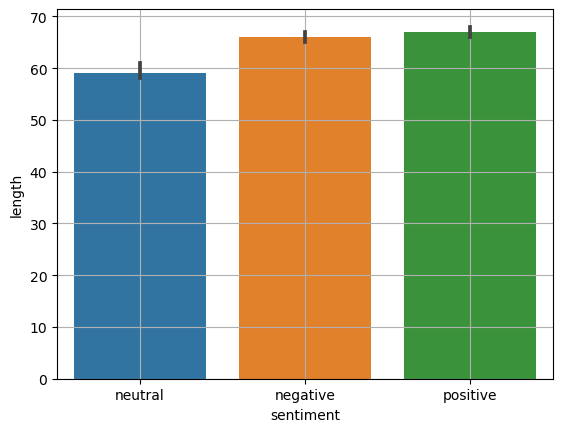

In [10]:
## visualize median tweet length


We aren't seeing a big difference here in the lengths of tweets.  Both positive and negative seem to averag about 70 characters.  Neutral tweets seem to be somewhat shorter on average.

# Frequency Distribution

Let's take a look at how often different words appear in the tweets.  

The NLTK FreqDist class expects a list of all tokens in all documents.  We can create this with the `.explode()` method to create new rows for every word.  We can then convert the resulting series to a list with `to_list()` to pass to the `FreqDist` class constructor.

In [11]:
## Create list of all tokens in all documents


['2am', 'feedings', 'for', 'the', 'baby', 'are', 'fun', 'when', 'he', 'is']

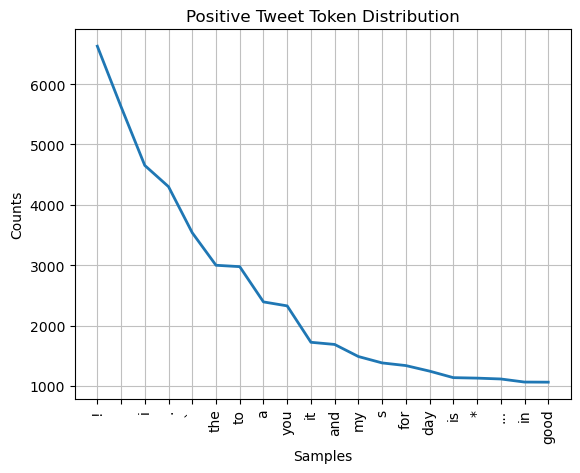

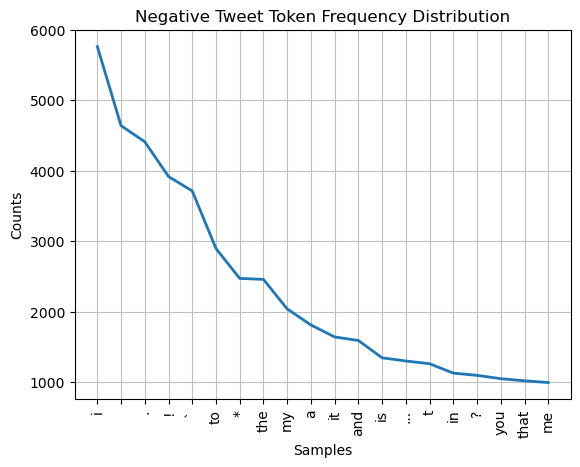

In [12]:
## Instantiate positive frequency distribution



## Plot the distribution



We can see already that punctuation and very common words are at the top of both lists.  To avoid this, we can use our normalized data instead.  Let's use our lemmas!

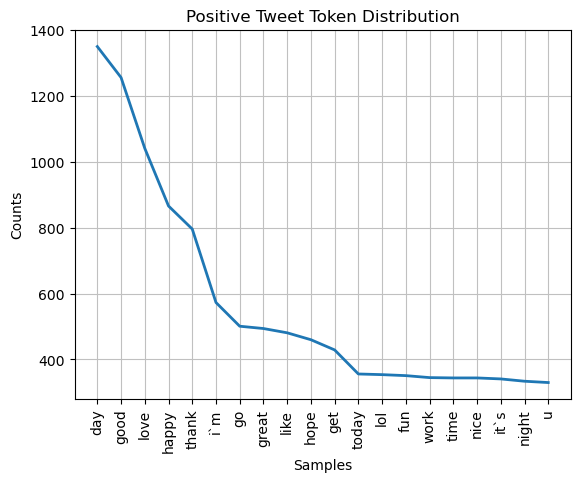

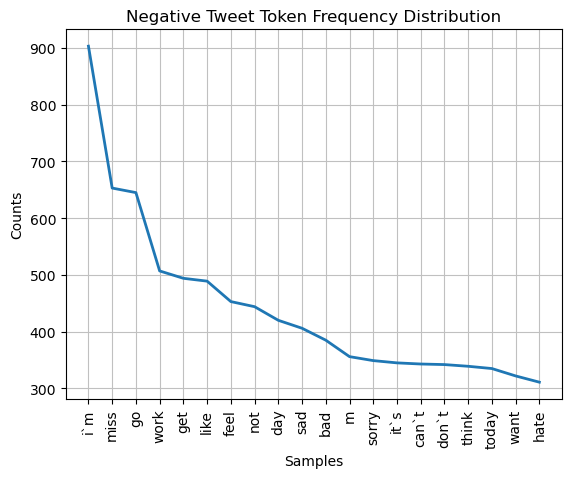

In [13]:
## Create list of all tokens in all documents



## Instantiate positive frequency distribution



## Plot the distribution



These are more informative!  We see words like 'good', 'love', 'hope', 'great', and 'nice' in the positives and 'miss', 'work', 'sad', 'bad', and 'hate' in negatives.

While this may not be surprising with positive and negative sentiments, if we were classifying other kinds of text, like spam emails or patent applications, it could be very enlightening!

# Word Clouds

Word Clouds tell us the same kinds of things as a frequency distribution, but are a nice way to visualize.  They can be used for project headers or presentations.

The `WordCloud` class expects texts to be one long string, so.  We will use our lemmas again, so we have to join all the tokens for each document into one long string.

## Processing the data for WordCloud

WordCloud expects one single string of all the words in a corpus.  since we already have a list of all the words, for each sentiment, we can just join those.

In [14]:
## Join the words for each sentiment



str

## Creating and displaying the Word Clouds

We will create the clouds and generate the images below.  We want to focus on larger words, otherwise we get some strange results due to contractions.  We will tell WordCloud to only generate words with 2 or more letters.

(-0.5, 399.5, 199.5, -0.5)

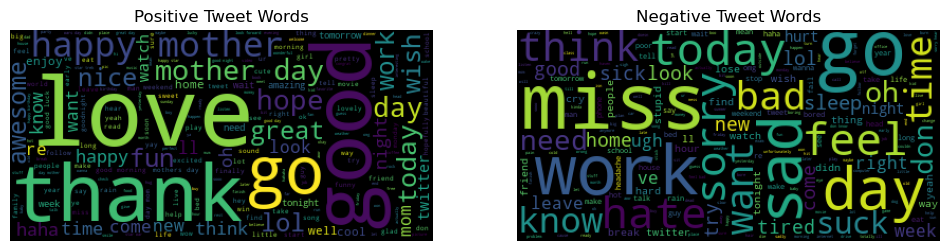

In [15]:
## Generate the WordCloud Images



## Plot the Images

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
axes[0].imshow(pos_cloud)
axes[0].set_title('Positive Tweet Words')
axes[0].axis('off')

axes[1].imshow(neg_cloud)
axes[1].set_title('Negative Tweet Words')
axes[1].axis('off')



This can be a fun way to help you stakeholders get a feel for the token distributions in our data.

# N-gram Analysis

We can do something similar with ngrams.  NLTK has native classes for finding and measuring the frequency of ngrams as well.

For this we need 2 objects: a measures class depending on the measure we want to see and a finder class based on the number of words in our ngram.

These classes exist for bi, tri, and quadgrams, but we will just focus on bigrams.

## Calcuate Frequency Scores

In [16]:
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

## Create measure classes



## Create collector classes



In [17]:
## Calculate positive and negative ngram scores






## Display the frequency scores



,positive ngram,positive score
0,"(mother`s, day)",0.005146
1,"(happy, mother`s)",0.004256
2,"(good, morning)",0.002359
3,"(mother, day)",0.002012
4,"(mothers, day)",0.001765
5,"(go, to)",0.001666
6,"(happy, mother)",0.001567
7,"(happy, mothers)",0.001567
8,"(can`t, wait)",0.001287
9,"(good, luck)",0.001204


,negative ngram,negative score
0,"(go, to)",0.003104
1,"(feel, like)",0.001922
2,"(i`m, go)",0.001515
3,"(i`m, sorry)",0.001275
4,"(look, like)",0.001072
5,"(don`t, know)",0.000850
6,"(will, not)",0.000776
7,"(feel, bad)",0.000758
8,"(sorry, hear)",0.000758
9,"(don`t, like)",0.000684


## Plot Frequency Scores

<Axes: title={'center': 'Negative Ngram Frequency'}, xlabel='negative ngram'>

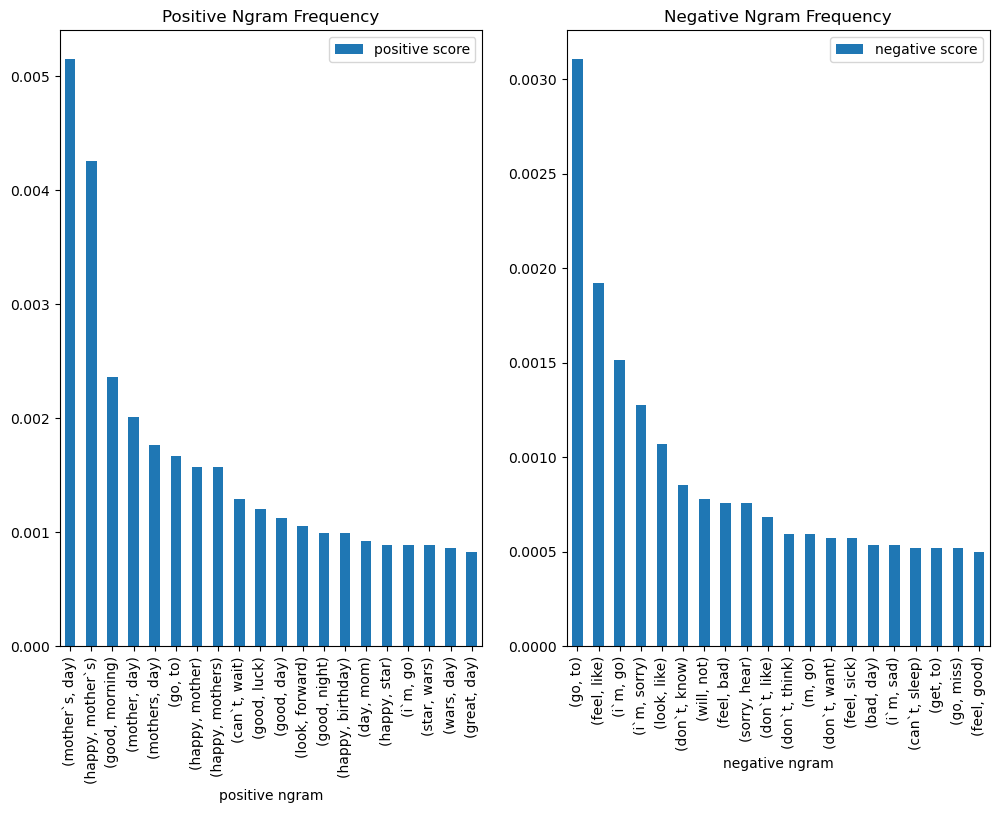

In [18]:
## Create a figure and axes
fig, axes = plt.subplots(1,2, figsize=(12,8))

## Plot the ngram frequencies



This might be more enlightening than the individual word frequency counts.  There are some relatable bigrams here.

We are also seeing a lot of versions of 'happy mother's day' which may tell us that more normalization is required here.  This would be a consideration in longer term projects.

# Preparing Data for Modeling

In this lesson we will be using a Bag of Words approach to modeling.  This means our final features will be just the counts of how many times each word appears in each document.  

We have many versions of our data to choose from for modeling.  Our lemmas are probably the most normalized, but our raw tokens have the most information.  The others are somewhere in between.  In this notebook we will be using the lemmatized data.  

We will try both the CountVectorizer and TfidfVectorizer for vectorization.  Both create a column for every word in the vocabulary.

**CountVectorizer** adds the raw counts of each word for each document.  It can be very sensitive to stop words, so we want to be sure to 

**TfidifVectorizer** adds a value that represents how unique the word is to the document, compared to all other documents in the corpus.  The more times a word appears in a document and the fewer times it appears in other documents the higher the value will be for that word.

Both of these vectorizers assume that documents will be single strings.  We will join our lemmas together again.

In [19]:
## Import Modeling Package
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV

In [20]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

## Validation Split

We will perform a triple split.  That way we can tune our model to a validation set and test the final version on a test set.  This avoid tuning our model to specifically perform well on just one set of testing data and gives us a better idea of how our model will perform on new data.

In [21]:
def join_tokens(token_list):
    joined_tokens = ' '.join(token_list)
    return joined_tokens

X = df['spacy_lemmas'].apply(join_tokens)
y = df['sentiment']
X.head(10)

0                             i`d respond go
1                    sooo sad miss san diego
2                                 boss bully
3                            interview leave
4                   son couldn`t release buy
5    shameless plug good rangers forum earth
6               2 feeding baby fun smile coo
7                                 soooo high
8                                           
9           journey wow u cool hehe possible
Name: spacy_lemmas, dtype: object

In [22]:
## Split data into train, test, val
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.3, random_state=42)
X_train.head()

21911                                       morning load 2day goin walk 1st rid nite haribo`
24540                                                 know it`s sprain it` repetitive injury
26262                                                                  bestie twitpic bestie
22393                                                                       check work sorry
27322    u guy say california angry tweet perez hilton jonathan upset spell california wrong
Name: spacy_lemmas, dtype: object

Here we see more opportunities for normalization.  In future iterations we could use RegEx to remove the web links or email addresses.

## Modeling

We are going to use a Multinomial Naive Bayes model.  Bayesian models have been shown to often perform well with text data.  However, we could use any classification model we wanted to.

We will be using a **Bag of Words** approach to classififying this text.  It's called **Bag of Words** because it's like we just put the words for each document into a bag.  We will not respect the order of the words, only which words are in the text and how many times they appear.  The models will use the frequency of each word in each text to classify it.

## Data Preparation: Vectorization

We have texts that are variable in length, but our sklearn models require a standard input size.  How do we make this transformation?

Then answer is Vectorization!

We will be using 2 different forms of vectorization: Count Vectorization and TF-IDF Vectoriation

## Count Vectorization

This form of vectorization is the easier one to understand.  We will use the vocabulary of all unique token found in our training data and create a column for each one.  As you can image, this can be a lot of columns!  This is one reason that we want to normalize data and remove stop words.

We've already lemmatized our data and removed stop words, but if we hadn't CountVectorizer could do that for us.  It can also create ngrams, strip accent marks, and more.  

One new feature we will use is `min_df`.  This will remove words that only appear a few times.  Remember that models need many examples of feature values in order to find patterns.  Tokens that only appear once or twice in the data will not be useful for our models to learn from.  Removing them will further normalize the data and reduce the number of features.

We will also try including bigrams in our columns.  We can tell the vectorizer the range of ngrams to use with `ngram_range=`.  It takes a tuple of a lower and upper bound of ngrams.  For example, if we wanted unigrams (one token), bigrams, and trigrams, we would set `ngrame_range=(1,3)`.  In this case we will just use unigrams and bigrams.

[Here is the documention for CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to learn more

In [23]:
## Instantiate CountVectorizer



<19236x7658 sparse matrix of type '<class 'numpy.int64'>'
	with 124466 stored elements in Compressed Sparse Row format>

It would be great to examine the resulting data, but as you can see it's saved as a **sparse matrix**.  We can also see that there are over 100 thousand columns, so they would be difficult to explore.

A **Sparse Matrix** is a compressed form of a numpy array.  It sqeezes out all of the 0 values to save space.  Otherwise our vectorized dataset would be very large!!

## Model Pipeline

Like other transformers, sklearn Vectorizers can be used in pipelines with models.  We will create a pipeline with our vectorizer and our Naive Bayes model.

In [24]:
## Create and fit model pipeline for inference: count_pipe.



Pipeline(steps=[('countvectorizer',
                 CountVectorizer(min_df=3, ngram_range=(1, 2))),
                ('naivebayes', MultinomialNB())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.80      0.77      0.78      5425
     neutral       0.74      0.81      0.77      7774
    positive       0.83      0.77      0.80      6037

    accuracy                           0.78     19236
   macro avg       0.79      0.78      0.79     19236
weighted avg       0.79      0.78      0.78     19236



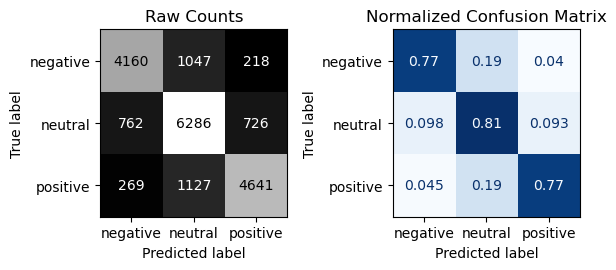


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.66      0.60      0.63       685
     neutral       0.60      0.68      0.64      1002
    positive       0.74      0.68      0.71       787

    accuracy                           0.66      2474
   macro avg       0.67      0.65      0.66      2474
weighted avg       0.66      0.66      0.66      2474



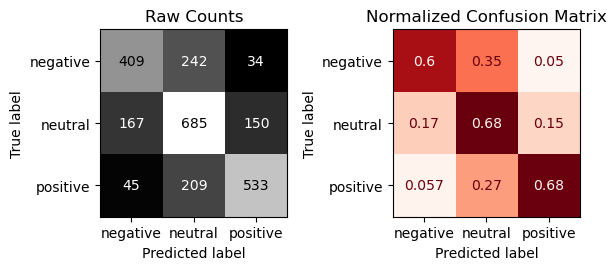

In [25]:
## Evaluate count_pipe
evaluate_classification(count_pipe, X_train, y_train, X_test, y_test)

Our model was 66% accurate, but did not seem overly biased against any given class.  There might be a slight bias toward the neutral class.

## TF-IDF Vectorization

Another popular **Bag of Words** vectorization strategy is TF-IDF vectorization.  In this stragegy, rather than just counting each word, we compare the frequency of a word in a document with the frequency of that word in other documents.  This measures the specificity of the word.

If a word is common in a document, but rare in the corpus as a whole, it gets a higher value.  If it's common throughout the corpus, it gets a lower value.  This helps TF-IDF vectorized data to resist the effects of common stop words or other words that tend to be common in that particular corpus.  They will have a lesser effect on the prediction.

[TfidfVectorizer Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [26]:
## Instantiate TF-IDF Vectorizor


## Instantiate model


## Create pipeline: tfidf_pipe



## Fit pipeline


                      

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 2))),
                ('bayes_model', MultinomialNB())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.87      0.64      0.74      5425
     neutral       0.67      0.89      0.77      7774
    positive       0.86      0.72      0.78      6037

    accuracy                           0.76     19236
   macro avg       0.80      0.75      0.76     19236
weighted avg       0.79      0.76      0.76     19236



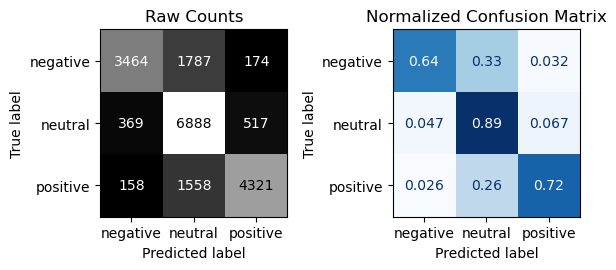


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.72      0.46      0.56       685
     neutral       0.56      0.79      0.66      1002
    positive       0.78      0.62      0.69       787

    accuracy                           0.64      2474
   macro avg       0.69      0.62      0.63      2474
weighted avg       0.67      0.64      0.64      2474



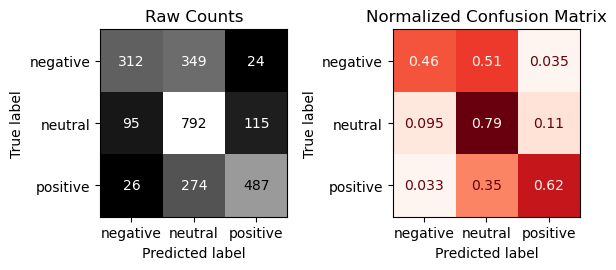

In [27]:
## Evaluate the tfidf_pipeline model
evaluate_classification(tfidf_pipe, X_train, y_train, X_test, y_test)

In this case we are seeing a stronger model bias toward the neutral class and an overall reduction in model accuracy.  The CountVectorizer seems to have been the better choice.

# Conclusion

There are a lot of choices in how to prepare data for text classification:
* Remove stop words and punctuation?
* Lemmatize?  Stem?
* How to Vectorize?
* ngrams?

## Challenge:

Try improving the score.  Ideas to try:
* Try a different version of the data: non-lemmatized data, include stop words, different range of n_grams
* Tune the vectorizer: Increase the min_df, decrease the max_df, other options: [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
* Tune the model: [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
* Try a different model: Can use any classification model for this.
* Consider PCA